In [6]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import time
from random import shuffle
import pandas as pd
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [7]:
X = np.load("MaskDataCorrected.npz")['X'][()] 

X.shape

(1578627, 1000)

In [8]:
y = np.load("MaskDataCorrected.npz")['y'][()] 

y.shape

(1578627,)

In [9]:
y

array([-1, -1, -1, ...,  1,  0,  1])

In [10]:
sum(y==-1)

50000

In [11]:
test_index = y==-1
train_labels = y[~test_index]
train_samples = X[~test_index,:]
test_samples = X[test_index, :]

In [12]:
train_samples.shape

(1528627, 1000)

In [14]:
import pickle
pkl_file = open('vocab.pkl', 'rb')
vocab = pickle.load(pkl_file)

In [15]:
vocab;

In [16]:
# shuffle data
index = range(train_samples.shape[0])
shuffle(index)
train_samples_ = train_samples[index, :]
train_labels_ = train_labels[index]

In [17]:
# extracting smaller sample to perform first analysis
X_sample = train_samples_[:1e5, :]
y_sample = train_labels_[:1e5]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.1, random_state=17)

In [19]:
X_test.shape

(10000, 1000)

In [45]:
from sklearn import preprocessing
X_test_sc = preprocessing.scale(X_test.todense())
X_train_sc = preprocessing.scale(X_train.todense())

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [43]:
X_train.todense()

matrix([[1, 4, 1, ..., 0, 0, 0],
        [4, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 1, 2, ..., 0, 0, 0],
        [4, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# Decision Tree

In [100]:
from sklearn import tree

In [171]:
clf_DT = tree.DecisionTreeClassifier(max_depth=60)
start = time.time()
clf_DT.fit(X_train, y_train)
end = time.time()

y_pred_DT = clf_DT.predict(X_test)
print accuracy_score(y_test, y_pred_DT)
print end-start

0.6765
28.589165926


In [172]:
y_pred_proba = clf_DT.predict_proba(X_test.toarray())[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc(fpr, tpr)

0.68492329915148931

# Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression

In [109]:
clf_LG = LogisticRegression(C=1)
start = time.time()
clf_LG.fit(X_train, y_train)
end = time.time()
print "time:", end-start

time: 1.70266199112


In [110]:
y_pred_LG = clf_LG.predict(X_test)
accuracy_score(y_test, y_pred_LG)

0.76200000000000001

In [144]:
y_pred_LG_proba = clf_LG.predict_proba(X_test)[:,1]

In [150]:
from sklearn.metrics import roc_curve, auc

def ROC_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

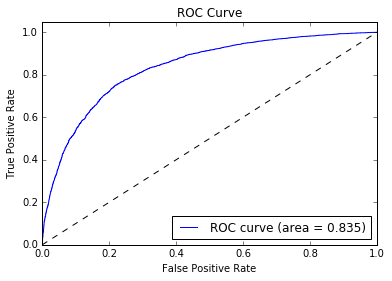

In [151]:
ROC_curve(y_test, y_pred_LG_proba)

In [173]:
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion matrix")

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print cm

[[3693 1316]
 [1064 3927]]


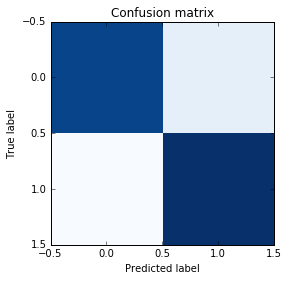

In [174]:
draw_confusion_matrix(y_test, y_pred_LG)

In [149]:
fpr, tpr, _ = roc_curve(y_test, y_pred_LG_proba)
auc(fpr, tpr)

0.83519118601944276

In [ ]:
# with scaled data
clf_LG_sc = LogisticRegression()
clf_LG_sc.fit(X_train_sc, y_train)
y_pred_LG_sc = clf_LG_sc.predict(X_test_sc)
accuracy_score(y_test, y_pred_LG_sc)

In [75]:
# cross-validation
from sklearn.grid_search import GridSearchCV
clf_LG = LogisticRegression()
C_values = [1e-2, 0.1, 1, 10]
k=10
est_LG = GridSearchCV(estimator=clf_LG, param_grid=dict(C=C_values), cv=k)
est_LG.fit(X_sample, y_sample)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [76]:
est_LG.grid_scores_

[mean: 0.75226, std: 0.00195, params: {'C': 0.01},
 mean: 0.76115, std: 0.00255, params: {'C': 0.1},
 mean: 0.76152, std: 0.00179, params: {'C': 1},
 mean: 0.76170, std: 0.00167, params: {'C': 10}]

In [77]:
est_LG.best_estimator_.C

10

In [82]:
from sklearn.linear_model import LogisticRegressionCV
clf_logreg_cv = LogisticRegressionCV()
clf_logreg_cv.fit(X_sample, y_sample)

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10], class_weight=None, cv=None,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [83]:
clf_logreg_cv.scores_

{1: array([[ 0.74719506,  0.76066479,  0.76099478,  0.76096478],
        [ 0.74557509,  0.75715486,  0.75823484,  0.75904482],
        [ 0.75129005,  0.76158046,  0.76131045,  0.76053042]])}

In [63]:
clf_LG = LogisticRegression()
start=time.time()
clf_LG.fit(train_samples, train_labels)
end=time.time()
print end-start

37.8012599945


In [64]:
y_pred_kaggle_lg = clf_LG.predict(test_samples)

In [65]:
y_pred_kaggle_lg.shape

(50000,)

In [21]:
# for Kaggle submissions
def write_csv(fileout, y_pred):
    output_fp = open(fileout, 'wb')
    output = csv.writer(output_fp)
    output.writerow(('id', 'y'))
    for i in range(len(y_pred)):
        output.writerow((i+1, y_pred[i]))

In [67]:
write_csv('LogReg.csv', y_pred_kaggle_lg)

# Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
clf_RF = RandomForestClassifier(n_estimators=100)
start=time.time()
clf_RF.fit(X_train, y_train)
end=time.time()
print end-start

320.468254089


In [121]:
y_pred_RF = clf_RF.predict(X_test)
accuracy_score(y_test, y_pred_RF)

0.74470000000000003

In [153]:
y_pred_RF_proba = clf_RF.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_RF_proba)
auc(fpr, tpr)

0.82355804832807655

In [ ]:
from sklearn import cross_validation
scores = cross_val_score(clf_RF, train_samples, train_labels, cv=10)

In [ ]:
scores

# Boosting

In [123]:
from sklearn.ensemble import GradientBoostingClassifier

In [124]:
clf_boosting = GradientBoostingClassifier(n_estimators=1000)

clf_boosting.fit(X_train, y_train)

y_pred_boosting = clf_boosting.predict(X_test.toarray())
accuracy_score(y_test, y_pred_boosting)

0.76170000000000004

In [155]:
y_pred_proba = clf_boosting.predict_proba(X_test.toarray())[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc(fpr, tpr)

0.83681451127901652

# SVM

In [111]:
from sklearn import svm

In [112]:
clf_svc = svm.LinearSVC()
clf_svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [113]:
y_pred_svc = clf_svc.predict(X_test)
accuracy_score(y_test, y_pred_svc)

0.76300000000000001

In [16]:
from sklearn.grid_search import GridSearchCV
clf_svm = svm.LinearSVC()
C_values = [1e-2, 0.1, 1, 10]
k=5
est_svm = GridSearchCV(estimator=clf_svm, param_grid=dict(C=C_values), cv=k)
est_svm.fit(X_sample, y_sample)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [17]:
est_svm.grid_scores_

[mean: 0.76047, std: 0.00146, params: {'C': 0.01},
 mean: 0.76068, std: 0.00178, params: {'C': 0.1},
 mean: 0.76070, std: 0.00174, params: {'C': 1},
 mean: 0.75817, std: 0.00261, params: {'C': 10}]

In [18]:
est_svm.best_estimator_.C

1

In [19]:
clf_svc_kaggle = svm.LinearSVC(C=1)
start = time.time()
clf_svc_kaggle.fit(train_samples, train_labels)
end = time.time()
print "time:", end-start

time: 550.328077078


In [20]:
y_pred_svc_kaggle = clf_svc_kaggle.predict(test_samples)

In [22]:
write_csv('LinearSVC.csv', y_pred_svc_kaggle)

# LDA

In [136]:
from sklearn.lda import LDA
clf_lda = LDA()
start = time.time()
clf_lda.fit(X_train.toarray(), y_train)
end = time.time()
y_pred_lda = clf_lda.predict(X_test.toarray())
print accuracy_score(y_test, y_pred_lda)
print "time:" , end-start

0.7612
time: 39.1627709866


In [157]:
y_pred_proba = clf_lda.predict_proba(X_test.toarray())[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc(fpr, tpr)

0.83428428308107727

In [115]:
from sklearn.qda import QDA
clf_qda = QDA()
start = time.time()
clf_qda.fit(X_train.toarray(), y_train)
end = time.time()
y_pred_qda = clf_qda.predict(X_test.toarray())
print accuracy_score(y_test, y_pred_qda)
print "time:" , end-start

0.709
time: 32.1087760925


//anaconda/lib/python2.7/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [158]:
y_pred_proba = clf_qda.predict_proba(X_test.toarray())[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc(fpr, tpr)

0.72819593935484361

# Adaboost

In [128]:
from sklearn.ensemble import AdaBoostClassifier
clf_ada = AdaBoostClassifier(n_estimators=500)
start = time.time()
clf_ada.fit(X_train, y_train)
end = time.time()
y_pred_ada = clf_ada.predict(X_test)
print accuracy_score(y_test, y_pred_ada)
print "time:" , end-start

0.7566
time: 56.4150669575


In [159]:
y_pred_proba = clf_ada.predict_proba(X_test.toarray())[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc(fpr, tpr)

0.83206771589939954

In [24]:
clf_ada_kaggle = AdaBoostClassifier(n_estimators=5000)
start = time.time()
clf_ada_kaggle.fit(train_samples, train_labels)
end = time.time()
print "time:" , end-start

time: 23852.1744659


In [ ]:
y_pred_ada_kaggle = clf_ada_kaggle.predict(test_samples)

# Bagging

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(max_samples=0.5, max_features=0.5)
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=0.5, max_samples=0.5,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [26]:
y_pred_bagging = bagging.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred_bagging)

0.70699999999999996

In [161]:
y_pred_proba = bagging.predict_proba(X_test.toarray())[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc(fpr, tpr)

0.78751495154844298

# Naive Bayes

In [37]:
X_sample2 = train_samples_[:1e6, :]
y_sample2 = train_labels_[:1e6]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_sample2, y_sample2, test_size=0.1, random_state=17)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [116]:
from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [117]:
y_pred_NB = clf_NB.predict(X_test)

In [118]:
accuracy_score(y_test, y_pred_NB)

0.73819999999999997

In [162]:
y_pred_proba = clf_NB.predict_proba(X_test.toarray())[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc(fpr, tpr)

0.81253681261927291

# PCA

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_r = pca.fit(X_sample.toarray()).transform(X_sample.toarray())
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [ 0.16677599  0.1294987   0.07770223  0.04902577  0.03066381  0.02595061
  0.0192008   0.01852476  0.01788911  0.01532929]


//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


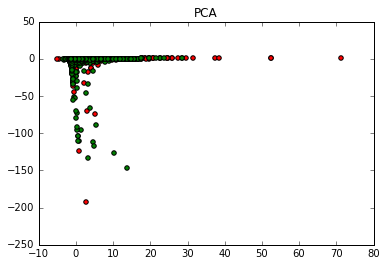

In [21]:
plt.figure()
plt.scatter(X_r[np.where(y_sample == 0), 0], X_r[np.where(y_sample == 0), 1], c='red')
plt.scatter(X_r[np.where(y_sample == 1), 0], X_r[np.where(y_sample == 1), 1], c='green')
plt.legend()
plt.title('PCA')
plt.show()